In [1]:
from pathlib import Path
import itertools
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy import spatial
import scipy
from sklearn import metrics

In [2]:
def correct_lat_shift(lat, shift):
    lat = lat - shift
    if lat < 0: lat = 0 
    shift = 0
    return lat, shift

In [3]:
def data_for_clustering(df, sel_bps, lat, shift):
    if 'tailtip' in sel_bps: sel_bps.remove('tailtip')
    if 'nose' in sel_bps: sel_bps.remove('nose')
           
    start = int(shift)           
    end = start + lat
    df = df.iloc[start:end]
    bp = sel_bps[0]
    df_aux = df[bp].dropna(axis=0)
    x = df_aux['x'].to_numpy()
    y = df_aux['y'].to_numpy()
    labels = np.zeros_like(x)
    
    for i, bp in enumerate(sel_bps[1:]):
        df_aux = df[bp].dropna(axis=0)
        x_aux = df_aux['x'].to_numpy()
        y_aux = df_aux['y'].to_numpy()
        x = np.hstack((x, x_aux))
        y = np.hstack((y, y_aux))
        labels = np.hstack((labels, (i+1) * np.ones_like(x_aux)))

    X = np.vstack((x,y))

    return X.T, labels

In [4]:
main_dir = '/home/stef/projects/rotariu_zalcman_2025'

xlsx_dir = main_dir + '/files_xlsx'

pickle_dir = main_dir + '/results/pickle/'
plots_dir = main_dir + '/results/plots/'

In [5]:
frame_rate = 30
n_groups = 5
n_mice = 4 
n_days = 5
n_trials = 10 * n_days 

In [6]:
gm_list = list(itertools.product(range(1,n_groups+1),range(1,n_mice+1)))
# sel_gm_list = list(itertools.product(range(3,4),range(1,n_mice+1)))
sel_gm_list = gm_list

mice = ['G{:d}_mus{:d}'.format(gm[0],gm[1]) for gm in gm_list]

silhouette_score_dict = {key : [] for key in mice}
ch_score_dict = {key : [] for key in mice} # Calinski-Harabasz score
db_score_dict = {key : [] for key in mice} #  Davies-Bouldin score


In [7]:
df_valid_trial =  pd.read_excel(xlsx_dir + "/valid_trials.xlsx") > 0
df_lat_sec = pd.read_excel(xlsx_dir + "/latency_to_fall.xlsx")
df_lat = df_lat_sec.multiply(frame_rate)

In [8]:
for (group,mouse) in sel_gm_list:
    
    print('Processing G{:d}, mus{:d}'.format(group,mouse))
    
    mouse_name = 'G{:d}_mus{:d}'.format(group,mouse)
    sel_mouse = 'mus' + str(mouse)
    
    # file_to_open = pickle_dir + 'results_nointerp_std3_shift1_group' + str(group) + '.pickle'
    file_to_open = pickle_dir + 'results_group' + str(group) + '.pickle'
    results = pickle.load(open(file_to_open, "rb"))
    
    df_mouse = results[sel_mouse + '_df']
    times = results['times_dict']
    shift_name = 'G{:d}_shift'.format(group) 
    
    silhouettes_scores = []
    ch_scores = []
    db_scores = []

    for trial in range(1,n_trials+1):
        print('Processing Trial{:d}'.format(trial))
        
        s_score = np.nan 
        ch_score = np.nan
        db_score = np.nan 
        it = trial-1
        valid_trial = df_valid_trial[mouse_name].iloc[it]
        if valid_trial:
            df = df_mouse['Trial'+str(trial)]         
            df.columns = df.columns.remove_unused_levels()
            bodyparts = df.columns.levels[0].tolist()

            lat, shift = tuple(df_lat[[mouse_name,shift_name]].iloc[it].values)   
            if group > 2:
                lat, shift = correct_lat_shift(lat, shift)
            X, labels = data_for_clustering(df, bodyparts, lat, shift)
            n_labels = np.unique(labels).shape[0]
            if X.shape[0] == 0:
                print('WARNING X shape, trial {:d}'.format(trial))
                s_score = np.nan  
                ch_score = np.nan
                db_score = np.nan
            elif n_labels < 2:
                print('WARNING n_labels, trial {:d}'.format(trial))

                s_score = np.nan 
                ch_score = np.nan
                db_score = np.nan
            else:        
                s_score = metrics.silhouette_score(X,labels)    
                ch_score = metrics.calinski_harabasz_score(X,labels) 
                db_score = metrics.davies_bouldin_score(X,labels) 


        silhouettes_scores.append(s_score)
        ch_scores.append(ch_score)
        db_scores.append(db_score)
            
            
    
    silhouette_score_dict[mouse_name] = silhouettes_scores
    ch_score_dict[mouse_name] = ch_scores
    db_score_dict[mouse_name] = db_scores        


Processing G1, mus1
Processing Trial1
Processing Trial2
Processing Trial3
Processing Trial4
Processing Trial5
Processing Trial6
Processing Trial7
Processing Trial8
Processing Trial9
Processing Trial10
Processing Trial11
Processing Trial12
Processing Trial13
Processing Trial14
Processing Trial15
Processing Trial16
Processing Trial17
Processing Trial18
Processing Trial19
Processing Trial20
Processing Trial21
Processing Trial22
Processing Trial23
Processing Trial24
Processing Trial25
Processing Trial26
Processing Trial27
Processing Trial28
Processing Trial29
Processing Trial30
Processing Trial31
Processing Trial32
Processing Trial33
Processing Trial34
Processing Trial35
Processing Trial36
Processing Trial37
Processing Trial38
Processing Trial39
Processing Trial40
Processing Trial41
Processing Trial42
Processing Trial43
Processing Trial44
Processing Trial45
Processing Trial46
Processing Trial47
Processing Trial48
Processing Trial49
Processing Trial50
Processing G1, mus2
Processing Trial1
P

# Save the results (splitting control and h3)

In [9]:
exclude_mice = True # they are alreay excluded in valid trials

control_h3_dict = {'G1_mus' + str(i): 'ctr' for i in range(1,5)}
control_h3_dict |= {'G2_mus' + str(i): 'h3' for i in range(1,5)}
control_h3_dict |= {'G' + str(j) + '_mus' + str(i): 'h3' for j in range(3,5) for i in [1,4]}
control_h3_dict |= {'G' + str(j) + '_mus' + str(i): 'ctr' for j in range(3,5) for i in [2,3]}
control_h3_dict |= {'G5_mus' + str(i): 'h3' for i in [1,3]}
control_h3_dict |= {'G5_mus' + str(i): 'ctr' for i in [2,4]}
control_h3_dict = dict(sorted(control_h3_dict.items()))

if exclude_mice == True:
    control_h3_dict.pop('G3_mus4')
    control_h3_dict.pop('G4_mus2')
    control_h3_dict.pop('G5_mus1')        
    

In [10]:
control_h3_dict

{'G1_mus1': 'ctr',
 'G1_mus2': 'ctr',
 'G1_mus3': 'ctr',
 'G1_mus4': 'ctr',
 'G2_mus1': 'h3',
 'G2_mus2': 'h3',
 'G2_mus3': 'h3',
 'G2_mus4': 'h3',
 'G3_mus1': 'h3',
 'G3_mus2': 'ctr',
 'G3_mus3': 'ctr',
 'G4_mus1': 'h3',
 'G4_mus3': 'ctr',
 'G4_mus4': 'h3',
 'G5_mus2': 'ctr',
 'G5_mus3': 'h3',
 'G5_mus4': 'ctr'}

In [11]:
ctr_h3_silh_dict = {'ctr': [], 'h3': []}
for key, val in control_h3_dict.items():
    print(key, val)
    ctr_h3_silh_dict[val].append(np.array(silhouette_score_dict[key]))
    
# for key, val in ctr_h3_silh_dict.items():
#     ctr_h3_silh_dict[key] = np.array(val)


G1_mus1 ctr
G1_mus2 ctr
G1_mus3 ctr
G1_mus4 ctr
G2_mus1 h3
G2_mus2 h3
G2_mus3 h3
G2_mus4 h3
G3_mus1 h3
G3_mus2 ctr
G3_mus3 ctr
G4_mus1 h3
G4_mus3 ctr
G4_mus4 h3
G5_mus2 ctr
G5_mus3 h3
G5_mus4 ctr


In [12]:
file_to_save = pickle_dir + 'ctr_h3_silh_results.pikcle'
results = {}
for i in ('ctr_h3_silh_dict',  
          'silhouette_score_dict',  
          'control_h3_dict'):
    results[i] = locals()[i]

with open(file_to_save, 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# sel_gm_list = list(itertools.product(range(1,3),range(1,n_mice+1)))
# sel_gm_list

Processing G2, mus2


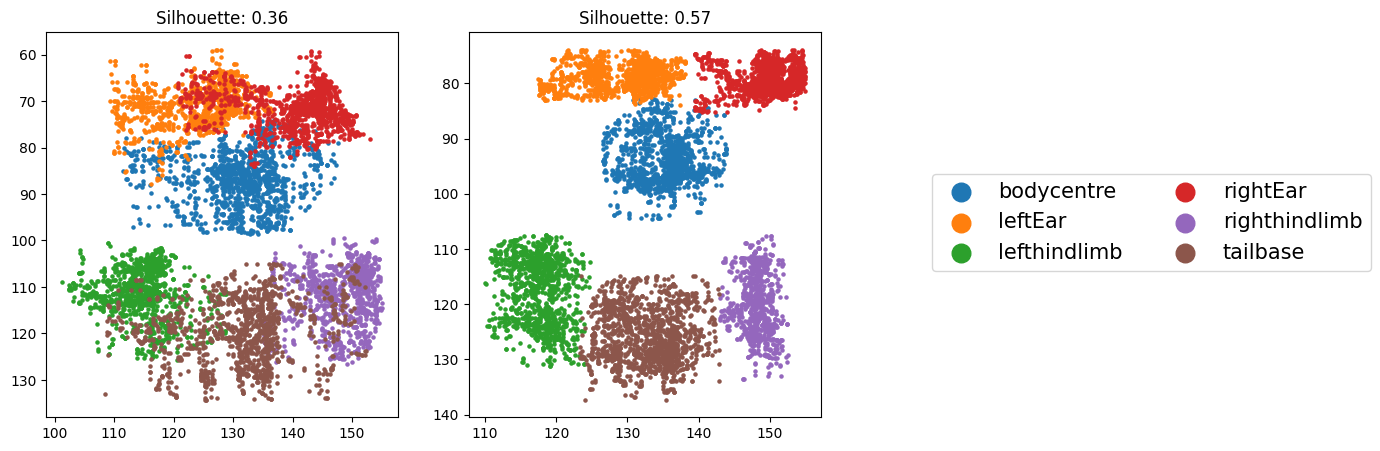

In [17]:
nrows = 1
ncols = 2
selcted_mouse = [sel_gm_list[5]]
selcted_trials = [6,16]
for (group,mouse) in selcted_mouse:
    
    print('Processing G{:d}, mus{:d}'.format(group,mouse))
    
    mouse_name = 'G{:d}_mus{:d}'.format(group,mouse)
    sel_mouse = 'mus' + str(mouse)
    
    file_to_open = pickle_dir + 'results_group' + str(group) + '.pickle'
    results = pickle.load(open(file_to_open, "rb"))
    
    df_mouse = results[sel_mouse + '_df']
    times = results['times_dict']
    shift_name = 'G{:d}_shift'.format(group) 
    

    fig_name = 'Scatterplots-selected' + mouse_name + '.png'  
    fig_path = plots_dir + fig_name
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(5*ncols,5*nrows))
    plt.subplots_adjust(hspace=0.4)
    axs = axs.flatten()
    iax = 0  
    for trial in selcted_trials:
        ax = axs[iax]
        df = df_mouse['Trial'+str(trial)]
        df.columns = df.columns.remove_unused_levels()
        bodyparts = df.columns.levels[0].tolist()
        it = trial-1
        lat, shift = tuple(df_lat[[mouse_name,shift_name]].iloc[it].values)
        if group > 2:
            lat, shift = correct_lat_shift(lat, shift)
        X, labels = data_for_clustering(df, bodyparts, lat, shift)           
        n_labels = np.unique(labels).shape[0]

        for ibp, bp in enumerate(bodyparts):
            mask = (labels == ibp) 
            ax.scatter(X[mask,0], X[mask,1], label=bp,s=5)
        ax.invert_yaxis()
        sil = silhouette_score_dict[mouse_name][it]
        chs = ch_score_dict[mouse_name][it]
        dbs = db_score_dict[mouse_name][it]

        ax.set_title('Silhouette: {:.2f}'.format(sil))
        iax += 1
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, markerscale=6, fontsize=15, ncol=2, loc='center left', bbox_to_anchor=(1, 0.5))
        
    fig.savefig(fig_path, format="png", bbox_inches="tight", dpi=100)